# Time Discretization Schemes

In [1]:
import numpy as np
import matplotlib.pylab as plt

There are some subtleties in how QuTiP discretizes controls versus the
requirements of a gradient-based optimization. Understanding these subtleties is
not critical for using this package (so you may skip this section of the
documentation), but it is important for anyone trying to re-implement Krotov's
method in another language.

QuTiP, in its propagation routine `mesolve`, takes
the controls to be exact at the values of the time grid (`tlist`), and
piecewise-constant in the range ±dt/2 around each grid points. That is,
controls
switch at the midpoint between any two points in `tlist`.

In contrast, Krotov's
method (as well as any other gradient method, such as
GRAPE) requires pulses to
be constant on the intervals of the time grid, and
switch *on* the time grid
points. The implementation of Krotov's method handles
this transparently: On
input and output, the controls in the `Objectives`
follow the convention in
QuTiP. Controls can be either functions that will be
evaluated at the points in
`tlist`, or an array of values of the same length as
`tlist`.Internally, Krotov
uses the `control_onto_interval` and
`pulse_onto_tlist` to convert the control
values to be constant on the
intervals of the time grid (resulting in an array
of pulse values that has one
value less than the points in `tlist`), and back:

In [2]:
import krotov
from krotov.structural_conversions import pulse_onto_tlist, control_onto_interval

The names of these routines reflects a convention used in the implementation,
where "controls" are defined on `tlist`, and "pulses" are defined on the
intervals of `tlist`.

The transformation between the two is invertible. Since
we generally care a lot about the boundaries of the controls (which often should
be exactly zero), the initial and final value of the control is kept unchanged
when converting to midpoints. For any other point, the "control" values at the
time grid points will be the average of the "pulse" values of the intervals
before and after that point on the time grid.

We can illustrate both sampling
conventions in a plot:

In [3]:
def plot_sampling_points(func, N=30, T=10, peg='gridpoints'):
    """Show the numerical sampling for a control `func`

    Args:
        func (callable): Callable control ``func(t, None)`` for every point on
            the time grid
        N (int): number of points on the time grid
        T (float): final time
        peg (str): If 'midpoints', make the sampling exact at the
            midpoints of the time grid. If 'gridpoints', make the sampling
            exact at the points of the time grid.
    """
    tlist = np.linspace(0, T, N)
    dt = tlist[1] - tlist[0]
    tlist_midpoints = []
    for i in range(len(tlist) - 1):
        tlist_midpoints.append(0.5 * (tlist[i+1] + tlist[i]))
    tlist_midpoints = np.array(tlist_midpoints)
    tlist_exact = np.linspace(0, 10, 100)

    if peg == 'midpoints':
        pulse = np.array([func(t, None) for t in tlist_midpoints])
        control = pulse_onto_tlist(pulse)
    elif peg == 'gridpoints':
        control = np.array([func(t, None) for t in tlist])
        pulse = control_onto_interval(control)
    else:
        raise ValueError("Invalid peg")

    fig, ax = plt.subplots(figsize=(9, 7))
    ax.plot(
        tlist_exact, func(tlist_exact, None), '-', color='black',
        label='exact')
    ax.errorbar(
        tlist_midpoints, pulse, fmt='o', xerr=dt/2, color='blue',
        label="sampled on intervals")
    ax.errorbar(
        tlist, control, fmt='o', xerr=dt/2, color='red',
        label="sampled on time grid")
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

We'll use a Blackman shape betwenn t=0 and T=10, as an example:

In [4]:
func = krotov.shapes.qutip_callback(krotov.shapes.blackman, t_start=0, t_stop=10)

If we did an optimization using that Blackman shape as a guess control, with
N=10 time grid points, the sampling would look as follows:

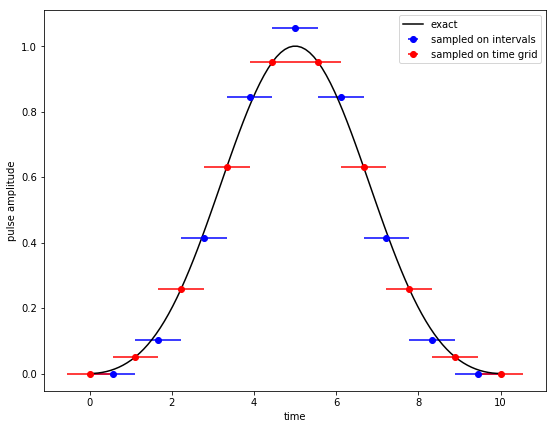

In [5]:
plot_sampling_points(func, N=10, peg="gridpoints")

The red points indicate the sampling that QuTiP would use when propagating the
guess control with `mesolve`. The blue points indicate the sampling that Krotov
will use internally: each iteration yields an update for the blue points, and
once the optimization finishes, the blue points are transformed back to the
sampling of the red points.

An important detail is that if the guess controls
are given as an (analytical) function, not an array, Krotov's `optimize_pulses`
will sample that function exactly onto `tgrid` before converting to the "guess
pulses" defined on the midpoints. This is what was visualized above. If the
controls were not discretized, but we were to choose the "pulses" based on the
analytical formula, we would end up with the following sampling:

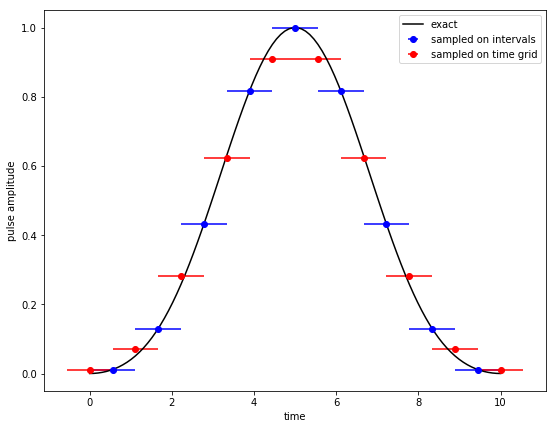

In [6]:
plot_sampling_points(func, N=10, peg="midpoints")

This exhibits a serious problem: After the transformation back to the sampling
points on the time grid at the end of the optimization, it does not preserve the
boundary values of the control to be zero at t=0 and t=T. Hence the choice
to
sample the control fields on input. Note that the same also applies to the
`shape` function in the `PulseOptions`: these are also first sampled on the
points of the time grid, and then converted to the interval representation, so
that initial and final values of zero are preserved.

Obviously, when using just
a few grid points as in the above plots, the result of a propagation may depend
significantly on the sampling (the blue/red points can deviate significantly
from the "exact" curve). This is the "discretization error": In order for the
optimization to be numerically useful, we must choose a time grid with a
sufficiently small dt so that the difference between the two sampling choices
becomes negligble:

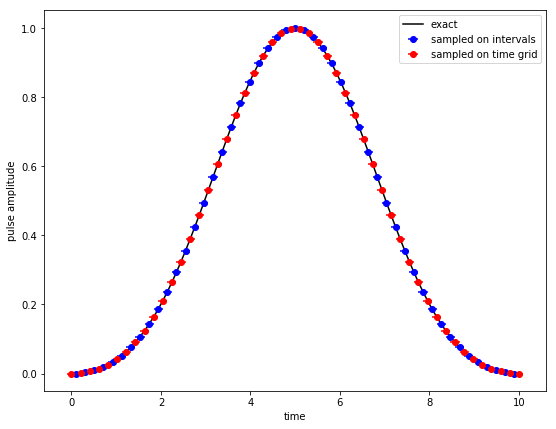

In [7]:
plot_sampling_points(func, N=50, peg="gridpoints")

The `Objective` class has two methods `mesolve` and `propagate` that simulate
the dynamics with the sampling on the grid points, and sampling on the
intervals, respectively. You may compare the two to estimate the discretization
error.

**Bonus**

If you run the notebook underlying this section of the
documentation
interactively (use the "launch binder" button at the top of the
page), you may
play around with your own choice of `func` and sampling points.

In [8]:
# NBVAL_SKIP
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib notebook

interact(
    plot_sampling_points,
    N=widgets.IntSlider(min=5,max=100,step=5,value=10),
    T=fixed(10),
    peg=['gridpoints', 'midpoints'],
    func=fixed(func));

<IPython.core.display.Javascript object>